# Optimal Growth Model with Policy Function Iteration using Julia

In [10]:
using BenchmarkTools
using Plots
pyplot()

Plots.PyPlotBackend()

In [1]:
mutable struct Model
    # primitive parameter
    beta::Float64 #subjective discount factor
    sigma::Float64 # relative risk aversion
    delta::Float64 #depriciation rate
    alpha::Float64 # capital share

    # discretize asset space
    agrid::Array{Float64,1}
end


# working like np.argmax(matrix,axis=1)
function argmax(mat::Array{Float64,2})
    values, indices = findmax(mat,2)
    return ind2sub(size(mat),vec(indices))[2]
end

function PFI(m::Model)
    beta = m.beta
    sigma = m.sigma
    alpha = m.alpha
    delta = m.delta
    
    agrid =m.agrid
    const na = size(agrid, 1)
    
    #utility function
    u(c::Float64) = (c^(1.0-sigma))/(1.0-sigma)
    
    const penalty::Float64 = -1e10
    
    #initialize value function and so on
    util = zeros(na,na) # utility matrix
    reward = zeros(na,1) # new utility using policy
    v0 = zeros(na,1) # initial guess of value function
    Tv = zeros(na,1) # update value function
    pol_a =zeros(na,1) # policy function
    a_index::Array{Int64,1} =zeros(na)
    I = speye(na) # create sparse identity matrix
        
    
    #create consuption and utility matrix        
    for (i,today) in enumerate(agrid)
        for (j,next) in enumerate(agrid)
            c = today ^ alpha + (1.0-delta)*today - next
            @inbounds util[i,j] = u(c)
            if c <= 0.0
                @inbounds util[i,j] = penalty
            end
        end
    end

    #iteration settings
    const maxiter = 1000
    const tol =1e-5

    # Policy function iteration and using monotonicity
    for iter in 1 : maxiter
        gridstart::Int64 =1
        # calculate temp value function
        for i in 1:na
            vmin = penalty
            for j in gridstart:na
                @inbounds v = util[i,j] + beta*v0[j]
                if v > vmin
                    vmin = copy(v)
                    gridstart = j
                else
                    break
                end
            end
            @inbounds a_index[i] = gridstart
        end
        
        #a_index = argmax(v) # obtain policy function ver. index
        Q = spzeros(na,na)
        for i in 1:na
            @inbounds reward[i] = u(agrid[i]^alpha + (1.0-delta)*agrid[i] - agrid[a_index[i]])#pol_a[i]) 
            @inbounds Q[i,a_index[i]] = 1.0
        end
        
        Tv = (I-beta*Q)\reward
        
        error = maximum(abs.(Tv-v0)) # update error
        v0    = copy(Tv) # update value function
        
        if error < tol
            for i in 1:na
                @inbounds pol_a[i]   = agrid[a_index[i]]
            end
            break
        end
    end
    
    return(agrid,v0,pol_a)
end

PFI (generic function with 1 method)

In [2]:
beta = 0.95 #subjective discount factor
sigma = 2.0 # relative risk aversion
delta = 0.1 #depriciation rate
alpha = 0.33 # capital share

# Steady state
aterm = 1.0/beta -(1.0 -delta)
kstar = alpha/aterm
kstar = kstar^(1.0/(1.0-alpha))

amin = 0.1 * kstar
amax = 2.0 * kstar
na   = 250

model = Model(beta, sigma, delta, alpha, linspace(amin, amax, na))

Model(0.95, 2.0, 0.1, 0.33, [0.316086, 0.340205, 0.364324, 0.388443, 0.412562, 0.436681, 0.4608, 0.484919, 0.509038, 0.533157  …  6.10465, 6.12877, 6.15289, 6.17701, 6.20113, 6.22524, 6.24936, 6.27348, 6.2976, 6.32172])

In [3]:
agrid,v0, pol_a = PFI(model)

([0.316086, 0.340205, 0.364324, 0.388443, 0.412562, 0.436681, 0.4608, 0.484919, 0.509038, 0.533157  …  6.10465, 6.12877, 6.15289, 6.17701, 6.20113, 6.22524, 6.24936, 6.27348, 6.2976, 6.32172], [-22.9351; -22.7698; … ; -15.6819; -15.672], [0.484919; 0.509038; … ; 5.95994; 5.95994])

In [12]:
@time PFI(model);

  0.015313 seconds (2.38 k allocations: 4.676 MiB)


In [7]:
@benchmark PFI(model)

LoadError: [91mUndefVarError: @benchmark not defined[39m

In [8]:
plot(agrid,pol_a ,color="blue", linewidth=1.5, label="Policy Function")
plot!(agrid,agrid, color="red", linewidth=1.5, label="45 degree Line")

LoadError: [91mUndefVarError: plot not defined[39m


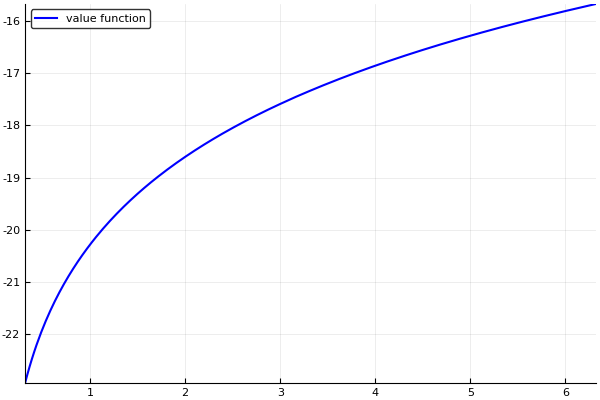

In [12]:
plot(agrid,v0,color="blue",lw=1.5,label="value function")

In [9]:
@code_warntype PFI(model)

Variables:
  #self# <optimized out>
  m::Model
  j@_3::Int64
  next::Float64
  #temp#@_5 <optimized out>
  c::Float64
  #temp#@_7::Tuple{Int64,Int64}
  i@_8::Int64
  today::Float64
  #temp#@_10 <optimized out>
  #temp#@_11::Tuple{Int64,Int64}
  v::Float64
  j@_13::Int64
  #temp#@_14::Int64
  vmin::Float64
  i@_16::Int64
  #temp#@_17::Int64
  i@_18::Int64
  #temp#@_19::Int64
  i@_20::Int64
  #temp#@_21::Int64
  iter@_22 <optimized out>
  gridstart::Int64
  Q::SparseMatrixCSC{Float64,Int64}
  #temp#@_25::Int64
  na::Int64
  penalty <optimized out>
  maxiter <optimized out>
  tol <optimized out>
  beta::Float64
  sigma::Float64
  alpha::Float64
  delta::Float64
  agrid::Array{Float64,1}
  u::#u#1{Float64}
  util::Array{Float64,2}
  reward::Array{Float64,2}
  v0::Array{Float64,2}
  Tv::Array{Float64,2}
  pol_a::Array{Float64,2}
  a_index::Array{Int64,1}
  I@_42::SparseMatrixCSC{Float64,Int64}
  error::Float64
  n@_44 <optimized out>
  n@_45 <optimized out>
  #temp#@_46::Float64
  #temp#@_4

      SSAValue(65) = (Base.add_int)(SSAValue(63), 1)::Int64
      # meta: pop location
      $(Expr(:inbounds, :pop))
      SSAValue(190) = (Core.tuple)((Base.getfield)(#temp#@_7::Tuple{Int64,Int64}, 1)::Int64, SSAValue(64))::Tuple{Int64,Float64}
      SSAValue(191) = (Core.tuple)((Base.add_int)((Base.getfield)(#temp#@_7::Tuple{Int64,Int64}, 1)::Int64, 1)::Int64, SSAValue(65))::Tuple{Int64,Int64}
      SSAValue(8) = SSAValue(190)
      SSAValue(192) = (Base.getfield)(SSAValue(8), 1)::Int64
      SSAValue(193) = (Base.add_int)(1, 1)::Int64
      j@_3::Int64 = SSAValue(192)
      SSAValue(194) = (Base.getfield)(SSAValue(8), 2)::Float64
      SSAValue(195) = (Base.add_int)(2, 1)::Int64
      next::Float64 = SSAValue(194)
      #temp#@_7::Tuple{Int64,Int64} = SSAValue(191) # line 48:
      $(Expr(:inbounds, false))
      # meta: location math.jl ^ 699
      SSAValue(68) = $(Expr(:foreigncall, "llvm.pow.f64", Float64, svec(Float64, Float64), :(today), 0, :(alpha), 0, :($(Expr(:llvmcall)))))

      # meta: location multidimensional.jl done 224
      SSAValue(136) = (Core.getfield)(#temp#@_77::CartesianIndex{1}, :I)::Tuple{Int64}
      SSAValue(137) = (Base.getfield)(SSAValue(136), 1)::Int64
      # meta: pop location
      unless (Base.not_int)((Base.slt_int)(SSAValue(171), SSAValue(137))::Bool)::Bool goto 391
      SSAValue(155) = #temp#@_77::CartesianIndex{1}
      SSAValue(156) = $(Expr(:new, CartesianIndex{1}, :((Core.tuple)((Base.add_int)((Base.getfield)((Core.getfield)(#temp#@_77, :I)::Tuple{Int64}, 1)::Int64, 1)::Int64)::Tuple{Int64})))
      #temp#@_77::CartesianIndex{1} = SSAValue(156) # line 67:
      n#671::Int64 = (Base.add_int)((Base.sub_int)(SSAValue(170), 1)::Int64, 1)::Int64 # line 68:
      unless (Base.slt_int)(0, n#671::Int64)::Bool goto 389 # line 70:
      i#672::Int64 = 0 # line 71:
      NewvarNode(:(val_1::Float64))
      NewvarNode(:(result::Float64))
      358: 
      unless (Base.slt_int)(i#672::Int64, n#671::Int64)::Bool goto 387 # line 72:
     